In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from sklearn import preprocessing
import seaborn as sns
import pickle
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale

In [2]:
df_identity_train = pd.read_csv("../Data/train_identity.csv")
df_transaction_train = pd.read_csv("../Data/train_transaction.csv")
df_identity_test = pd.read_csv("../Data/test_identity.csv")
df_transaction_test = pd.read_csv("../Data/test_transaction.csv")

In [3]:
# Seen from https://www.kaggle.com/kabure/almost-complete-feature-engineering-ieee-data#V-Features
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df

In [4]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        # print(name)
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [5]:
pd.set_option("display.max_rows", 500)

In [6]:
df_train = pd.merge(df_transaction_train, df_identity_train, how = "left", on = "TransactionID")
df_test = pd.merge(df_transaction_test, df_identity_test, how = "left", on = "TransactionID")

In [7]:
print("shape of df_identity_train: ", df_identity_train.shape)
print("shape of df_transaction_train: ", df_transaction_train.shape)
print("shape of df_train: ", df_train.shape)

shape of df_identity_train:  (144233, 41)
shape of df_transaction_train:  (590540, 394)
shape of df_train:  (590540, 434)


In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
one_val_cols =      [col for col in df_train.columns if df_train[col].nunique()<=1] +\
                        [col for col in df_test.columns if df_test[col].nunique()<=1]
missing_val_cols =  [col for col in df_train.columns if df_train[col].isnull().sum()/df_train.shape[0]>0.9] +\
                        [col for col in df_test.columns if df_test[col].isnull().sum()/df_test.shape[0]>0.9]
same_val_cols =     [col for col in df_train.columns if df_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9] +\
                        [col for col in df_test.columns if df_test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
cols_to_drop = list(set(one_val_cols + missing_val_cols + same_val_cols))
print(cols_to_drop)

['V108', 'V136', 'V65', 'V301', 'V309', 'V114', 'V67', 'V115', 'V320', 'V113', 'V104', 'V125', 'V298', 'D7', 'V286', 'V27', 'V319', 'V133', 'V28', 'id_21', 'V25', 'V86', 'V132', 'V14', 'dist2', 'V281', 'V88', 'V305', 'V55', 'V134', 'V26', 'V297', 'V101', 'V107', 'V119', 'V106', 'V105', 'V135', 'id_25', 'id_08', 'V118', 'id_07', 'V98', 'V311', 'V102', 'V121', 'V316', 'V112', 'C3', 'id_27', 'V295', 'id_23', 'id_18', 'V110', 'V23', 'V89', 'V117', 'V137', 'V68', 'V318', 'id_24', 'V109', 'V284', 'V123', 'id_22', 'id_26', 'V24', 'V116', 'V124', 'V299', 'V321', 'V66', 'V111', 'V293', 'V296', 'V77', 'V120', 'V122', 'V300', 'V129', 'V103', 'V290', 'isFraud']


In [9]:
cols_to_drop.remove('isFraud')

In [10]:
df_train.drop(cols_to_drop, axis = 1, inplace = True)
df_test.drop(cols_to_drop, axis = 1, inplace = True)

# df_train.fillna(-999, inplace = True)
# df_test.fillna(-999, inplace = True)

In [11]:
def make_day_feature(df, offset=0.58, tname='TransactionDT'):
    """
    Creates a day of the week feature, encoded as 0-6.
    """
    days = df[tname] / (3600 * 24)
    encoded_days = np.floor(days - 1 + offset) % 7
    return encoded_days

def make_hour_feature(df, tname='TransactionDT'):
    """
    Creates an hour of the day feature, encoded as 0-23.
    """
    hours = df[tname] / (3600)
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

In [12]:
df_train["Weekday"] = make_day_feature(df_train)
df_train["Hour"]= make_hour_feature(df_train)
df_test["Weekday"] = make_day_feature(df_test)
df_test["Hour"] = make_hour_feature(df_test)

In [13]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 
          'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 
          'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 
          'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 
          'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other',
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 
          'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 
          'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 
          'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple',
          -999:"undefined"}
us_emails = ['gmail', 'net', 'edu']
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest_df-579654
for col in ['P_emaildomain', 'R_emaildomain']:
    df_train[col + '_pre'] = df_train[col].map(emails)
    df_test[col + '_pre'] = df_test[col].map(emails)
    
    df_train[col + '_suffix'] = df_train[col].map(lambda x: str(x).split('.')[-1])
    df_test[col + '_suffix'] = df_test[col].map(lambda x: str(x).split('.')[-1])
    
    df_train[col + '_suffix'] = df_train[col + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[col + '_suffix'] = df_test[col + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [14]:
categorical = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2",
               "P_emaildomain", "R_emaildomain"] +  ["M" + str(i) for i in range(1, 10)] +\
                    ['DeviceType', 'DeviceInfo', 'Weekday', 'Hour',
                     'P_emaildomain_pre', 'P_emaildomain_suffix', 'R_emaildomain_pre',
                     'R_emaildomain_suffix', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 
                     'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [15]:
# Label encoding
category_counts = {}
for col in categorical:
    df_train[col] = df_train[col].replace("nan", "other")
    df_train[col] = df_train[col].replace(np.nan, "other")
    df_test[col] = df_test[col].replace("nan", "other")
    df_test[col] = df_test[col].replace(np.nan, "other")
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df_train[col].values) + list(df_test[col].values))
    df_train[col] = lbl.transform(list(df_train[col].values))
    df_test[col] = lbl.transform(list(df_test[col].values))
    category_counts[col] = len(list(lbl.classes_)) + 1

In [16]:
category_counts

{'ProductCD': 6,
 'card1': 17092,
 'card2': 503,
 'card3': 135,
 'card4': 6,
 'card5': 140,
 'card6': 6,
 'addr1': 443,
 'addr2': 95,
 'P_emaildomain': 62,
 'R_emaildomain': 62,
 'M1': 4,
 'M2': 4,
 'M3': 4,
 'M4': 5,
 'M5': 4,
 'M6': 4,
 'M7': 4,
 'M8': 4,
 'M9': 4,
 'DeviceType': 4,
 'DeviceInfo': 2801,
 'Weekday': 8,
 'Hour': 25,
 'P_emaildomain_pre': 10,
 'P_emaildomain_suffix': 10,
 'R_emaildomain_pre': 10,
 'R_emaildomain_suffix': 10,
 'id_12': 4,
 'id_13': 57,
 'id_14': 30,
 'id_15': 5,
 'id_16': 4,
 'id_17': 129,
 'id_19': 570,
 'id_20': 549,
 'id_28': 4,
 'id_29': 4,
 'id_30': 88,
 'id_31': 173,
 'id_32': 8,
 'id_33': 463,
 'id_34': 6,
 'id_35': 4,
 'id_36': 4,
 'id_37': 4,
 'id_38': 4}

In [ ]:
del df_train["TransactionID"]
del df_train["TransactionDT"]
del df_test["TransactionID"]
del df_test["TransactionDT"]

In [19]:
resumetable(df_train)

Dataset Shape: (590540, 358)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000.0,2987001.0,2987002.0,19.17
1,isFraud,int64,0,2,0.0,0.0,0.0,0.22
2,TransactionDT,int64,0,573349,86400.0,86401.0,86469.0,19.11
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.35
4,ProductCD,int64,0,5,4.0,4.0,4.0,1.28
5,card1,int64,0,13553,12696.0,1726.0,3597.0,9.97
6,card2,int64,0,501,501.0,304.0,390.0,6.34
7,card3,int64,0,115,50.0,50.0,50.0,0.70
8,card4,int64,0,5,1.0,2.0,4.0,1.11
9,card5,int64,0,120,42.0,2.0,66.0,2.70


In [22]:
Vcols = []
for i in range(1, 340):
    col = "V"+str(i)
    if col in df_train.columns:
        print(col, df_train[col].min(), df_train[col].max(), df_train[col].nunique())
        Vcols.append(col)

V1 0.0 1.0 2
V2 0.0 8.0 9
V3 0.0 9.0 10
V4 0.0 6.0 7
V5 0.0 6.0 7
V6 0.0 9.0 10
V7 0.0 9.0 10
V8 0.0 8.0 9
V9 0.0 8.0 9
V10 0.0 4.0 5
V11 0.0 5.0 6
V12 0.0 3.0 4
V13 0.0 6.0 7
V15 0.0 7.0 8
V16 0.0 15.0 15
V17 0.0 15.0 16
V18 0.0 15.0 16
V19 0.0 7.0 8
V20 0.0 15.0 15
V21 0.0 5.0 6
V22 0.0 8.0 9
V29 0.0 5.0 6
V30 0.0 9.0 8
V31 0.0 7.0 8
V32 0.0 15.0 15
V33 0.0 7.0 7
V34 0.0 13.0 13
V35 0.0 3.0 4
V36 0.0 5.0 6
V37 0.0 54.0 55
V38 0.0 54.0 55
V39 0.0 15.0 16
V40 0.0 24.0 18
V41 0.0 1.0 2
V42 0.0 8.0 9
V43 0.0 8.0 9
V44 0.0 48.0 49
V45 0.0 48.0 49
V46 0.0 6.0 7
V47 0.0 12.0 9
V48 0.0 5.0 6
V49 0.0 5.0 6
V50 0.0 5.0 6
V51 0.0 6.0 7
V52 0.0 12.0 9
V53 0.0 5.0 6
V54 0.0 6.0 7
V56 0.0 51.0 52
V57 0.0 6.0 7
V58 0.0 10.0 11
V59 0.0 16.0 17
V60 0.0 16.0 17
V61 0.0 6.0 7
V62 0.0 10.0 11
V63 0.0 7.0 8
V64 0.0 7.0 8
V69 0.0 5.0 6
V70 0.0 6.0 7
V71 0.0 6.0 7
V72 0.0 10.0 11
V73 0.0 7.0 8
V74 0.0 8.0 9
V75 0.0 4.0 5
V76 0.0 6.0 7
V78 0.0 31.0 32
V79 0.0 7.0 8
V80 0.0 19.0 20
V81 0.0 19.0 20
V82 0.0 7.

In [17]:
# Shape before applying PCA on V features
Y_train = df_train["isFraud"]

In [18]:
del df_train["isFraud"]

In [19]:
df_test.shape

(506691, 357)

In [20]:
df = pd.concat([df_train, df_test], axis=0, join='outer')
df = df.reset_index()
df.index.nunique()

1097231

In [ ]:
df_train.describe()

In [ ]:
Vcols

In [ ]:
# scaler = StandardScaler()
# scaler.fit(df)
# scaled_df = scaler.transform(df)

In [23]:
# Don't think fillna -999 will work well with PCA

for col in Vcols:
    df[col].fillna((df[col].min() - 2), inplace=True)
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))  
    
df = PCA_change(df, Vcols, prefix='PCA_V_', n_components=20)


In [27]:
df.shape

(1097231, 138)

In [28]:
df.columns[49:]

Index(['M7', 'M8', 'M9', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo', 'Weekday', 'Hour', 'P_emaildomain_pre',
       'P_emaildomain_suffix', 'R_emaildomain_pre', 'R_emaildomain_suffix',
       'PCA_V_0', 'PCA_V_1', 'PCA_V_2', 'PCA_V_3', 'PCA_V_4', 'PCA_V_5',
       'PCA_V_6', 'PCA_V_7', 'PCA_V_8', 'PCA_V_9', 'PCA_V_10', 'PCA_V_11',
       'PCA_V_12', 'PCA_V_13', 'PCA_V_14', 'PCA_V_15', 'PCA_V_16', 'PCA_V_17',
       'PCA_V_18', 'PCA_V_19', 'PCA_V_20', 'PCA_V_21', 'PCA_V_22', 'PCA_V_23',
       'PCA_V_24', 'PCA_V_25', 'PCA_V_26', 'PCA_V_27', 'PCA_V_28', 'PCA_V_29',
       'PCA_V_30', 'PCA_V_31', 'PCA_V_32', 'PCA_V_33', 'PCA_V_34', 'PCA_V_35',
       'PCA_V_36', 'PCA_V_37', 'PCA_V_38', 'PCA_V_39', 'PCA_V_40', 'PCA_V_41',
       '

In [ ]:
# PCA_V_0 -> PCA_V_49 are the principle component numerical feature gained from V1 -> V339

In [ ]:
resumetable(df)

In [29]:
for i in range(20):
    col = "PCA_V_"+str(i)
    print(df[col].min(), df[col].max())

-1.4876244007205415 3.0224910544208186
-1.57091011826102 1.6600664937349912
-1.432804619046758 1.6049815284204236
-1.0090182160507601 1.5035245783165827
-0.34964254241239 1.9001702232259705
-0.6412966306185496 1.4899044642708217
-0.5774155052433373 1.2688976926847366
-0.9407515837709304 1.9062248361766165
-0.6104628548955201 1.57664180894089
-0.8087371608109933 2.6516030666497628
-0.8306737417371701 0.8749566851789861
-1.0991492383234749 1.3263383173841365
-0.9377741454689686 1.1071653611806145
-0.5294843939267786 0.6960828347438942
-0.5005806031783805 0.6152069498336044
-0.7295294074065196 1.1470850714863163
-0.4416473165740634 0.719193809640908
-0.5564454975345979 2.5674587375740296
-0.35926966549379635 0.6217762278649104
-0.27918982467377385 0.49253750604755664
-0.8162260808889967 1.618971362729274
-0.41139653877688853 0.6763643248374142
-0.42353975674507804 0.5630220811804209
-0.7099232507848598 1.0301263289829279
-1.1859164493933134 1.3328351166942172
-0.5325582109314011 0.8937886

In [ ]:
R_domain_probability = df_train.groupby(['R_emaildomain'])["isFraud"].mean()
df_train.groupby(df_train["R_emaildomain"].isnull())["isFraud"].mean()

In [ ]:
df["R_emaildomain_factor"] = np.where((df["R_emaildomain"].isnull()), 0.020819, 0.081775)

P_domain_probability = df_train.groupby(['P_emaildomain'])['isFraud'].mean()
p = P_domain_probability.to_dict()
df["P_emaildomain_factor"] = df['P_emaildomain'].map(p).fillna(0.029538)
# df_train["P_emaildomain_factor"] = df_transaction_train['P_emaildomain'].map(p).fillna(0.029538)
# df_test["P_emaildomain_factor"] = df_transaction_test["P_emaildomain"].map(p).fillna(0.029538)

In [24]:
numerical = ["TransactionAmt", "dist1"] + ["C" + str(i) for i in range(1, 15)] + \
            ["D" + str(i) for i in range(1, 16)] + ["PCA_V_"+str(i) for i in range(20)] + \
            ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11']
numerical.remove("C3")
numerical.remove("D7")

In [33]:
print(df.shape)
print(len(categorical)+len(numerical))

(1097231, 138)
135


In [25]:
df = reduce_mem_usage(df)

Mem. usage decreased to 196.72 Mb (78.2% reduction)


In [36]:
for col in numerical:
    print(col, df[col].min(), df[col].max())

TransactionAmt 0.018 31940.0
dist1 0.0 10290.0
C1 0.0 4684.0
C2 0.0 5692.0
C4 0.0 2252.0
C5 0.0 376.0
C6 0.0 2252.0
C7 0.0 2256.0
C8 0.0 3332.0
C9 0.0 572.0
C10 0.0 3256.0
C11 0.0 3188.0
C12 0.0 3188.0
C13 0.0 2918.0
C14 0.0 1429.0
D1 0.0 641.0
D2 0.0 641.0
D3 0.0 1076.0
D4 -122.0 1091.0
D5 0.0 1088.0
D6 -83.0 1091.0
D8 0.0 2030.0
D9 0.0 0.9585
D10 0.0 1091.0
D11 -53.0 883.0
D12 -83.0 879.0
D13 0.0 1066.0
D14 -193.0 1085.0
D15 -83.0 1091.0
PCA_V_0 -1.487 3.023
PCA_V_1 -1.571 1.66
PCA_V_2 -1.433 1.605
PCA_V_3 -1.009 1.504
PCA_V_4 -0.3496 1.9
PCA_V_5 -0.641 1.49
PCA_V_6 -0.5776 1.269
PCA_V_7 -0.941 1.906
PCA_V_8 -0.6104 1.576
PCA_V_9 -0.8086 2.652
PCA_V_10 -0.8306 0.875
PCA_V_11 -1.1 1.326
PCA_V_12 -0.938 1.107
PCA_V_13 -0.5293 0.6963
PCA_V_14 -0.5005 0.615
PCA_V_15 -0.7295 1.147
PCA_V_16 -0.4417 0.719
PCA_V_17 -0.5566 2.568
PCA_V_18 -0.3594 0.6216
PCA_V_19 -0.2793 0.4924
PCA_V_20 -0.8164 1.619
PCA_V_21 -0.4114 0.6763
PCA_V_22 -0.4236 0.563
PCA_V_23 -0.71 1.03
PCA_V_24 -1.186 1.333
PCA_V

In [26]:
for col in numerical:
    if df[col].isnull().sum()>0:
        df[col] = df[col].fillna(df_train[col].mean())

In [ ]:
for col in categorical:
    print(col, df[col].dtype)

In [ ]:
# for col in categorical:
category_counts = {}
for col in categorical:
    df[col] = df[col].replace("nan", "other")
    df[col] = df[col].replace(np.nan, "other")
    
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df[col].values))
    
    df[col] = lbl.transform(list(df[col].values))
    category_counts[col] = len(list(lbl.classes_)) + 1

In [27]:
category_counts

{'ProductCD': 6,
 'card1': 17092,
 'card2': 503,
 'card3': 135,
 'card4': 6,
 'card5': 140,
 'card6': 6,
 'addr1': 443,
 'addr2': 95,
 'P_emaildomain': 62,
 'R_emaildomain': 62,
 'M1': 4,
 'M2': 4,
 'M3': 4,
 'M4': 5,
 'M5': 4,
 'M6': 4,
 'M7': 4,
 'M8': 4,
 'M9': 4,
 'DeviceType': 4,
 'DeviceInfo': 2801,
 'Weekday': 8,
 'Hour': 25,
 'P_emaildomain_pre': 10,
 'P_emaildomain_suffix': 10,
 'R_emaildomain_pre': 10,
 'R_emaildomain_suffix': 10,
 'id_12': 4,
 'id_13': 57,
 'id_14': 30,
 'id_15': 5,
 'id_16': 4,
 'id_17': 129,
 'id_19': 570,
 'id_20': 549,
 'id_28': 4,
 'id_29': 4,
 'id_30': 88,
 'id_31': 173,
 'id_32': 8,
 'id_33': 463,
 'id_34': 6,
 'id_35': 4,
 'id_36': 4,
 'id_37': 4,
 'id_38': 4}

In [28]:
for col in numerical:
    scaler = StandardScaler()
    if df[col].max() > 100 and df[col].min() >= 0:
        df[col] = np.log1p(df[col])
    scaler.fit(df[col].values.reshape(-1,1))
    df[col] = scaler.transform(df[col].values.reshape(-1,1))

/Users/ic3scar/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/ic3scar/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/ic3scar/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/ic3scar/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/ic3scar/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/ic3scar/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
 

In [41]:
resumetable(df)

Dataset Shape: (1097231, 138)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,index,int32,0,590540,0.000000e+00,1.000000e+00,2.000000e+00,19.14
1,TransactionID,int32,0,1097231,2.987000e+06,2.987001e+06,2.987002e+06,20.07
2,TransactionDT,int32,0,1068035,8.640000e+04,8.640100e+04,8.646900e+04,20.01
3,TransactionAmt,float16,0,2523,-1.348877e-01,-1.019531e+00,-2.907715e-01,7.66
4,ProductCD,int8,0,5,4.000000e+00,4.000000e+00,4.000000e+00,1.32
5,card1,int16,0,17091,1.269600e+04,1.726000e+03,3.597000e+03,10.01
6,card2,int16,0,502,5.010000e+02,3.040000e+02,3.900000e+02,6.33
7,card3,int16,0,134,5.000000e+01,5.000000e+01,5.000000e+01,0.78
8,card4,int8,0,5,1.000000e+00,2.000000e+00,4.000000e+00,1.11
9,card5,int16,0,139,4.200000e+01,2.000000e+00,6.600000e+01,2.70


In [42]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(1097231, 138)
(590540, 357)
(506691, 357)


In [29]:
df_train_v4 = df.iloc[:590540, :]
df_test_v4 = df.iloc[590540:, :]

In [30]:
Y_train.sum()

20663

In [45]:
df_test_v4.describe()

,index,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,PCA_V_40,PCA_V_41,PCA_V_42,PCA_V_43,PCA_V_44,PCA_V_45,PCA_V_46,PCA_V_47,PCA_V_48,PCA_V_49
count,506691.00000,5.066910e+05,5.066910e+05,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,...,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000
mean,253345.00000,3.916894e+06,2.692994e+07,-0.015160,3.116039,8797.759258,267.787727,54.014166,3.291941,100.502521,...,-0.007080,0.010887,0.010979,-0.005878,-0.020111,-0.002537,-0.009407,-0.005287,-0.001277,-0.000007
std,146269.23696,1.462692e+05,4.756507e+06,0.000000,1.493833,4798.697339,160.302997,13.823694,1.023213,40.537396,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.00000,3.663549e+06,1.840322e+07,-4.574219,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,-18.015625,-36.562500,-22.906250,-29.968750,-27.859375,-16.171875,-30.859375,-24.250000,-21.921875,-24.468750
25%,126672.50000,3.790222e+06,2.277154e+07,-0.691406,2.000000,4927.000000,115.000000,50.000000,2.000000,66.000000,...,-0.313477,-0.296631,-0.251221,-0.312500,-0.240479,-0.267090,-0.254150,-0.245239,-0.180176,-0.207397
50%,253345.00000,3.916894e+06,2.720466e+07,-0.143066,4.000000,8642.000000,275.000000,50.000000,4.000000,126.000000,...,-0.002310,0.002550,-0.034332,0.068298,0.015282,0.030762,-0.046295,-0.058411,-0.026291,0.033234
75%,380017.50000,4.043566e+06,3.134856e+07,0.489502,4.000000,13040.000000,414.000000,50.000000,4.000000,126.000000,...,0.251465,0.176270,0.218750,0.234497,0.250244,0.305908,0.156006,0.201050,0.263428,0.256104
max,506690.00000,4.170239e+06,3.421434e+07,5.113281,4.000000,17090.000000,501.000000,133.000000,4.000000,138.000000,...,28.171875,27.015625,33.875000,23.750000,30.312500,55.375000,31.359375,31.390625,42.625000,41.125000


In [31]:
# Ver4
df_train_v4.to_pickle("../Data/Training_set_ver4.pkl")
df_test_v4.to_pickle("../Data/Test_set_ver4.pkl")
Y_train.to_pickle("../Data/Training_set_Y_ver4.pkl")

In [ ]:
df_train_v4 = pd.read_pickle("../Data/Training_set_ver4.pkl")
df_test_v4 = pd.read_pickle("../Data/Test_set_ver4.pkl")

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from sklearn import preprocessing
import seaborn as sns
import pickle as pkl

import math
import tensorflow as tf
from keras import layers, regularizers
from keras.layers import Dense, Activation, Input, Concatenate, Embedding, Flatten, Dropout, BatchNormalization, SpatialDropout1D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.initializers import glorot_uniform
import keras.backend as K
from keras.models import Model, load_model, Sequential
from keras import optimizers

import sklearn
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve


Using TensorFlow backend.


In [ ]:
numerical

In [36]:
def get_input_features(df):
    X = {'numerical':np.array(df[numerical])}
    for col in categorical:
        X[col] = np.array(df[col])
    return X

def fc_nn_with_el():
    categorical_inputs = []
    for col in categorical:
        categorical_inputs.append(Input(shape=[1], name = col))
        
    categorical_embeddings = []
    for i, col in enumerate(categorical):
        categorical_embeddings.append(
            Embedding(category_counts[col], int(np.log1p(category_counts[col])+1), name = col+"_emb")(categorical_inputs[i]))
    
    categorical_logits = Concatenate(name = "categorical_conc")(
        [Flatten()(SpatialDropout1D(.1)(col_emb)) for col_emb in categorical_embeddings])
    
    numerical_inputs = Input(shape=[df_train_v4[numerical].shape[1]], name = "numerical")
    numerical_logits = Dropout(.1)(numerical_inputs)
    
    x = Concatenate()([categorical_logits, numerical_logits])
    
    x = Dense(200, activation = 'relu')(x)
    x = Dropout(.2)(x)
    x = Dense(150, activation = 'relu')(x)
    x = Dropout(.2)(x)
    output = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs = categorical_inputs + [numerical_inputs], outputs = output)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    return model

In [34]:
len(category_counts) == len(categorical)

True

In [35]:
X_train = get_input_features(df_train_v4)

In [ ]:
Y_train.sum()

In [37]:
    model = fc_nn_with_el()

W0811 08:14:35.668659 4378899904 deprecation_wrapper.py:119] From /Users/ic3scar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 08:14:35.718375 4378899904 deprecation_wrapper.py:119] From /Users/ic3scar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 08:14:36.118458 4378899904 deprecation_wrapper.py:119] From /Users/ic3scar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 08:14:36.125022 4378899904 deprecation_wrapper.py:119] From /Users/ic3scar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_defa

In [38]:
filepath = "../Data/NN_EL_Model_ver2_4.h5"
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=30, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callback_list = [checkpoint, reduce_lr]

In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ProductCD (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
card1 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
card2 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
card3 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
card4 (Inp

In [41]:
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 1024, callbacks = callback_list)

Epoch 1/100
590540/590540 [==============================] - 16s 27us/step - loss: 0.1107 - acc: 0.9686

Epoch 00001: loss improved from inf to 0.11073, saving model to ../Data/NN_EL_Model_ver2_4.h5
Epoch 2/100
590540/590540 [==============================] - 13s 22us/step - loss: 0.0834 - acc: 0.9759

Epoch 00002: loss improved from 0.11073 to 0.08341, saving model to ../Data/NN_EL_Model_ver2_4.h5
Epoch 3/100
590540/590540 [==============================] - 12s 20us/step - loss: 0.0781 - acc: 0.9774

Epoch 00003: loss improved from 0.08341 to 0.07807, saving model to ../Data/NN_EL_Model_ver2_4.h5
Epoch 4/100
590540/590540 [==============================] - 12s 20us/step - loss: 0.0744 - acc: 0.9786

Epoch 00004: loss improved from 0.07807 to 0.07442, saving model to ../Data/NN_EL_Model_ver2_4.h5
Epoch 5/100
590540/590540 [==============================] - 12s 20us/step - loss: 0.0719 - acc: 0.9793

Epoch 00005: loss improved from 0.07442 to 0.07187, saving model to ../Data/NN_EL_Model

Epoch 42/100
590540/590540 [==============================] - 13s 22us/step - loss: 0.0386 - acc: 0.9883

Epoch 00042: loss improved from 0.03909 to 0.03859, saving model to ../Data/NN_EL_Model_ver2_4.h5
Epoch 43/100
590540/590540 [==============================] - 13s 22us/step - loss: 0.0386 - acc: 0.9882

Epoch 00043: loss did not improve from 0.03859
Epoch 44/100
590540/590540 [==============================] - 13s 22us/step - loss: 0.0381 - acc: 0.9884 1s - loss: 0.0

Epoch 00044: loss improved from 0.03859 to 0.03810, saving model to ../Data/NN_EL_Model_ver2_4.h5
Epoch 45/100
590540/590540 [==============================] - 13s 22us/step - loss: 0.0379 - acc: 0.9884 1s -

Epoch 00045: loss improved from 0.03810 to 0.03785, saving model to ../Data/NN_EL_Model_ver2_4.h5
Epoch 46/100
590540/590540 [==============================] - 13s 22us/step - loss: 0.0377 - acc: 0.9884

Epoch 00046: loss improved from 0.03785 to 0.03768, saving model to ../Data/NN_EL_Model_ver2_4.h5
Epoch 47/10

In [42]:
preds = model.predict(X_train)

In [43]:
print(roc_auc_score(Y_train, preds))

0.9978300515091033


In [44]:
print(sklearn.metrics.f1_score(Y_train, preds>0.5))

0.9230090333298723


In [45]:
model2 = load_model("../Data/NN_EL_Model_ver2_4.h5")

In [46]:
X_test = get_input_features(df_test_v4)

In [47]:
predicts = model2.predict(X_test)

In [48]:
predicts.shape

(506691, 1)

In [ ]:
# Need to correct input part into the model

In [49]:
predicts.sum()

14257.663

In [50]:
submission = pd.read_csv('../Data/sample_submission.csv', index_col='TransactionID')
submission['isFraud'] = predicts
submission.to_csv('../Data/Y_test_v4.csv')

In [51]:
submission.shape

(506691, 1)

In [ ]:
df_y.to_csv("../Data/test_ver3.csv", index=False)

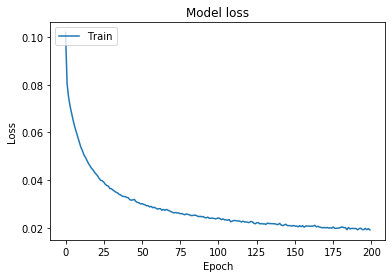

In [66]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()